# This notebook is for experimenting thresholds and other stuff

In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import ipywidgets as widgets
from ipywidgets import FloatSlider, interactive

%matplotlib inline

In [4]:
with open('calibration-images/camera_dist_pickle.p', 'rb') as fp:
    camera_dict = pickle.load(fp)

dist = camera_dict['dist']
mtx = camera_dict['mtx']

In [26]:
def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    #convert the input image into HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # grab the Saturation channel
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    # apply thresholding
    # selected pixles will equal to 1
    s_binary[ (s_channel >= sthresh[0]) & (s_channel <= sthresh[1]) ] = 1
    
    # convert the input image to HSV color space
    # grab the Value channel
    r_channel = image[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[ (r_channel >= vthresh[0]) & (r_channel <= vthresh[1]) ] = 1
    
    output = np.zeros_like(r_channel)
    # apply the And operator to take intersection between both binary images
    output[ (s_binary == 1) | (r_binary == 1) ] = 1
    return output

def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # cinvert input image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    output_binary = np.zeros_like(scaled_sobel)
    output_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return output_binary

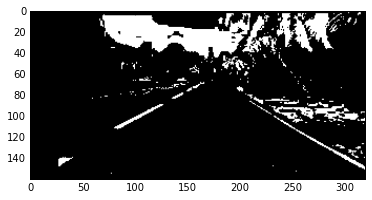

In [27]:
def update(r_low_tresh, r_high_tresh, s_low_tresh,s_high_tresh):
    raw = cv2.imread("test-images/straight5.jpg")

    undist = cv2.undistort(raw, mtx, dist, None, mtx)

    preprocessImage = np.zeros_like(undist[:,:,0])
    c_binary = color_threshold(undist, sthresh=(s_low_tresh, s_high_tresh), vthresh=(r_low_tresh, r_high_tresh))

    plt.imshow(c_binary,cmap='gray')
    
r_low_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=200)
r_high_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=255)
s_low_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=70)
s_high_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=255)

interactive(update,
            r_low_tresh= r_low_tresh,
            r_high_tresh= r_high_tresh,
            s_low_tresh= s_low_tresh,
            s_high_tresh= s_high_tresh )
# perspective_result = draw_perpestive_boundaries(undist, offset=offset)
# undist_warped, _ = warp(undist, offset=offset)
# binary_warped, Minv = warp(preprocessImage, offset)
# result = np.dstack((binary_warped,binary_warped,binary_warped)) * 255

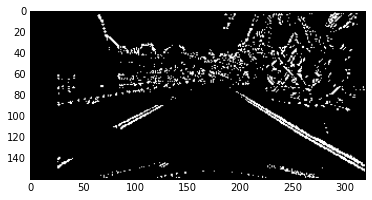

In [26]:
def update(r_low_tresh, r_high_tresh, s_low_tresh,s_high_tresh):
    raw = cv2.imread("test-images/straight5.jpg")

    undist = cv2.undistort(raw, mtx, dist, None, mtx)

    preprocessImage = np.zeros_like(undist[:,:,0])

    gradx = abs_sobel_thresh(undist, orient='x', thresh=(r_low_tresh, r_high_tresh))
    grady = abs_sobel_thresh(undist, orient='y', thresh=(s_low_tresh, s_high_tresh))
    preprocessImage[((gradx == 1) & (grady == 1))] = 255

    plt.imshow(preprocessImage,cmap='gray')
    
r_low_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=20)
r_high_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=255)
s_low_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=30)
s_high_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=255)

interactive(update,
            r_low_tresh= r_low_tresh,
            r_high_tresh= r_high_tresh,
            s_low_tresh= s_low_tresh,
            s_high_tresh= s_high_tresh )

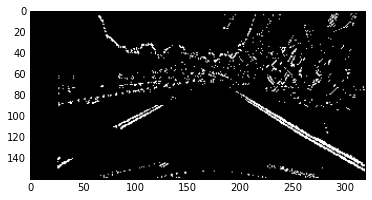

In [29]:
def update(r_low_tresh, r_high_tresh, s_low_tresh,s_high_tresh):
    raw = cv2.imread("test-images/straight5.jpg")

    undist = cv2.undistort(raw, mtx, dist, None, mtx)

    preprocessImage = np.zeros_like(undist[:,:,0])

    gradx = abs_sobel_thresh(undist, orient='x', thresh=(20, 255))
    grady = abs_sobel_thresh(undist, orient='y', thresh=(30, 255))
    c_binary = color_threshold(undist, sthresh=(200, 255), vthresh=(70, 255))
    preprocessImage[((gradx == 1) & (grady == 1) & (c_binary == 1))] = 255
    

    plt.imshow(preprocessImage,cmap='gray')
    
r_low_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=20)
r_high_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=255)
s_low_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=30)
s_high_tresh = FloatSlider(min=0.0, max=255.0, step=1, value=255)

interactive(update,
            r_low_tresh= r_low_tresh,
            r_high_tresh= r_high_tresh,
            s_low_tresh= s_low_tresh,
            s_high_tresh= s_high_tresh )


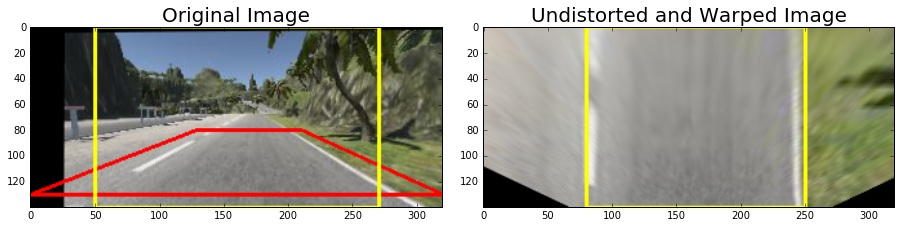

In [39]:
def update(leftx, lefty, rightx, righty):
    img = plt.imread('test-images/straight5.jpg')
    img = img[0:140,:,:]
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_graph = undist.copy()

    height_image = img.shape[0]
    width_image  = img.shape[1]

    rectangle = np.float32([[250, 0],
                      [80, 0],
                      [80, height_image], 
                      [250, height_image]])

    top_left = (129, 80)
    top_right = (210, 80)
    bottom_left = (-0, int(height_image * 0.93))
    bottom_right =  (width_image+0, int(height_image * 0.93))

    src = np.float32([[top_right[0], top_right[1]],
                      [top_left[0], top_left[1]],
                      [bottom_left[0], bottom_left[1]], 
                      [bottom_right[0], bottom_right[1]]])


    offset = 50

    dst = np.float32([[width_image - offset, 0 ], #top right
                    [offset, 0], # top left
                    [offset, height_image], # bottom left
                    [width_image- offset, height_image]]) #bottom right

    cv2.polylines(undist_graph, np.int32([src]), 1, (255,0,0), thickness=2)
    cv2.polylines(undist_graph, np.int32([dst]), 1, (255,255,0), thickness=2)

    M = cv2.getPerspectiveTransform(src, dst)

    top_down = cv2.warpPerspective(undist, M, (width_image, height_image), flags=cv2.INTER_LINEAR)

    cv2.polylines(top_down, np.int32([rectangle]), 1, (255,255,0), thickness=2)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    ax1.imshow(undist_graph)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(top_down)
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

leftx = FloatSlider(min=0.0, max=500, step=1, value=120)
lefty = FloatSlider(min=0.0, max=500.0, step=1, value=80)
rightx = FloatSlider(min=0.0, max=500.0, step=1, value=215)
righty = FloatSlider(min=0.0, max=500.0, step=1, value=80)

interactive(update,
            leftx = leftx,
            lefty = lefty,
            rightx= rightx,
            righty= righty )